In [1]:
# 04_hierarchical_demo.ipynb (Python Code exportiert als Skript zur Vorlage)

import matplotlib.pyplot as plt
from shapely.geometry import LineString
from planners.hierarchical_planner import HierarchicalPlanner  # korrekt benannt als HierarchicalPlanner bei dir?
from planners.lazy_prm import LazyPRM
from planners.basic_prm import BasicPRM
from planners.visibility_prm import VisibilityPRM
from utils.collision_checker import CollisionChecker
from utils.hierarchical_visualize import visualize_hierarchical_planning
from environment import get_all_scenes

scenes = get_all_scenes()
# Suche nach der U-Shape Szene in der Liste
scene_data = next((data for name, data in scenes if name == "Corridor"), None)
if scene_data:
    scene, limits, (start, goal) = scene_data
else:
    raise ValueError("Shape Szene nicht gefunden")


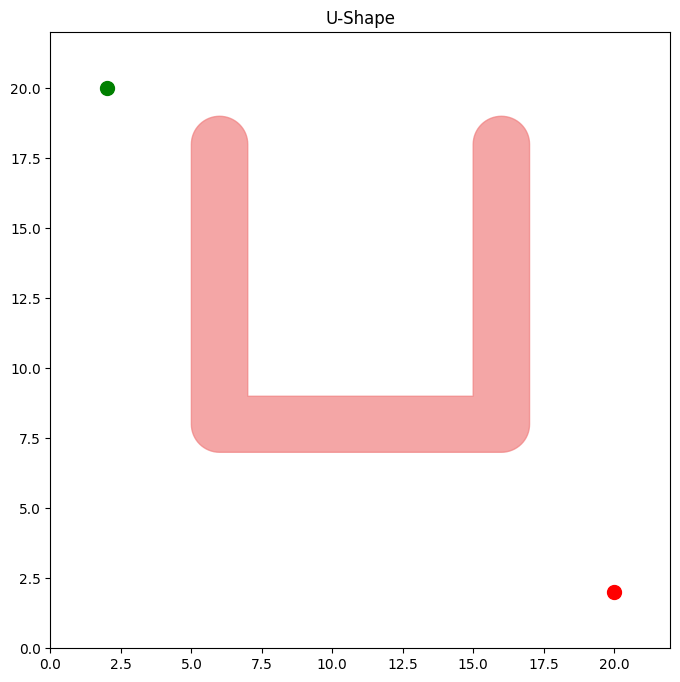

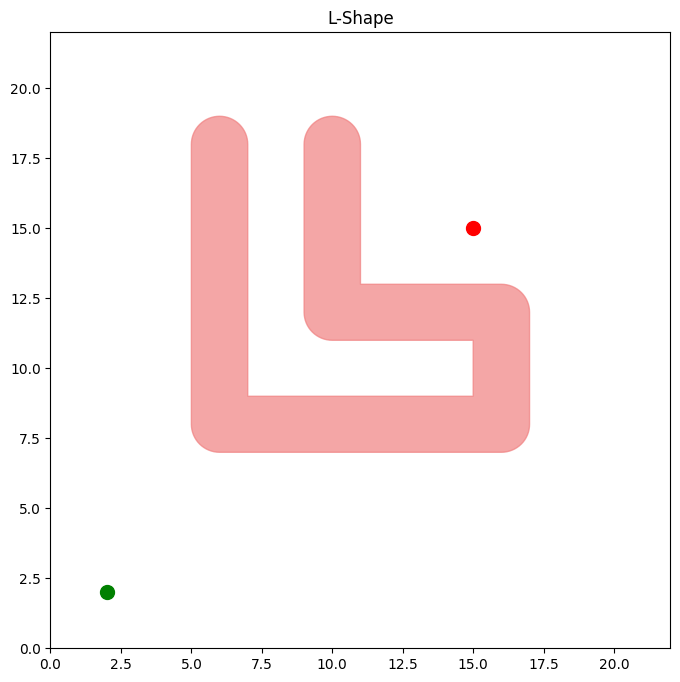

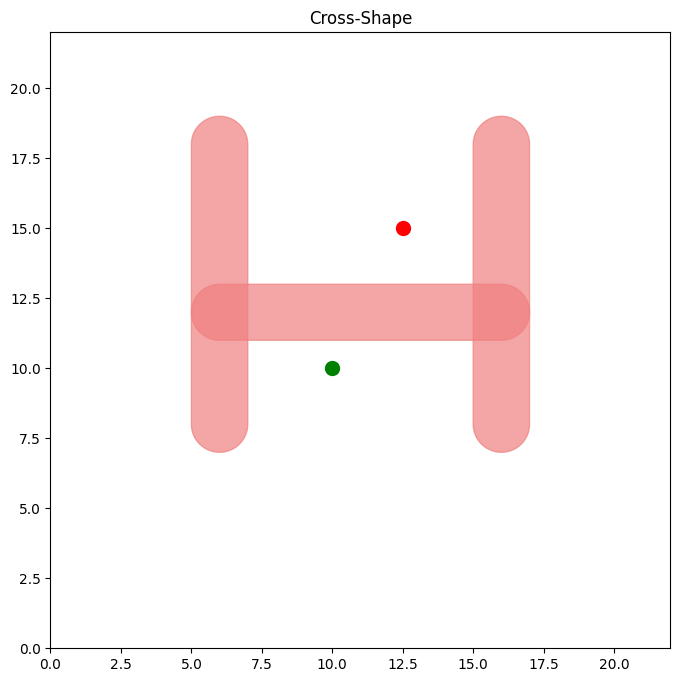

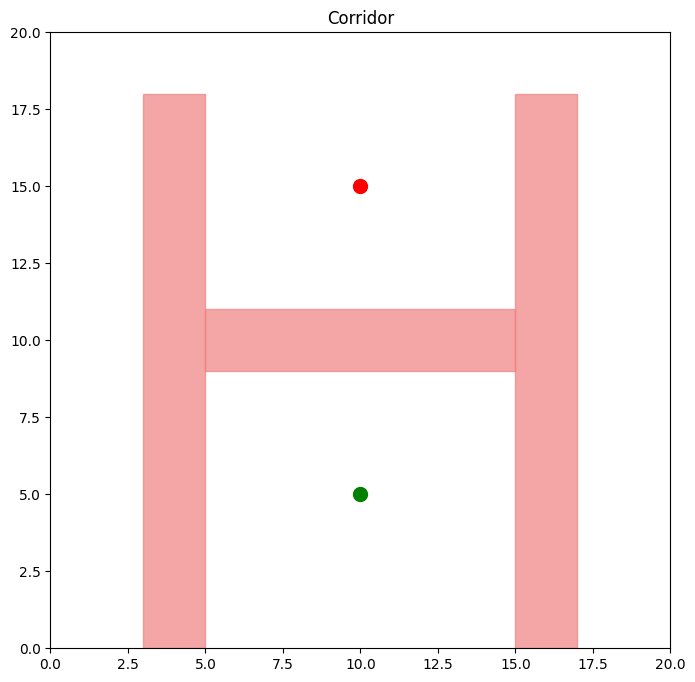

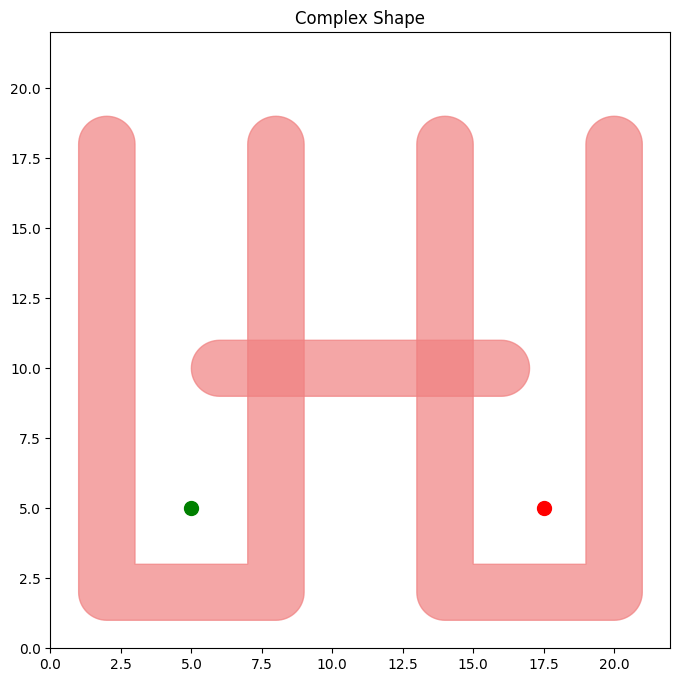

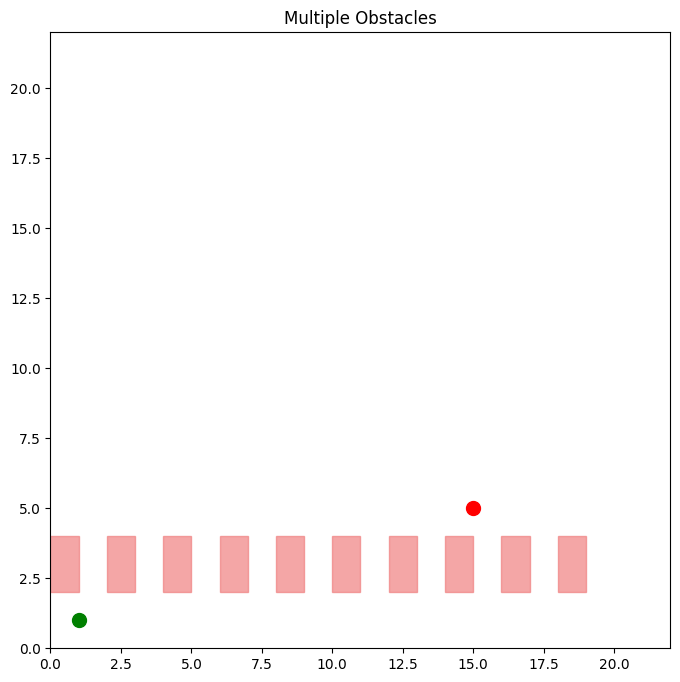

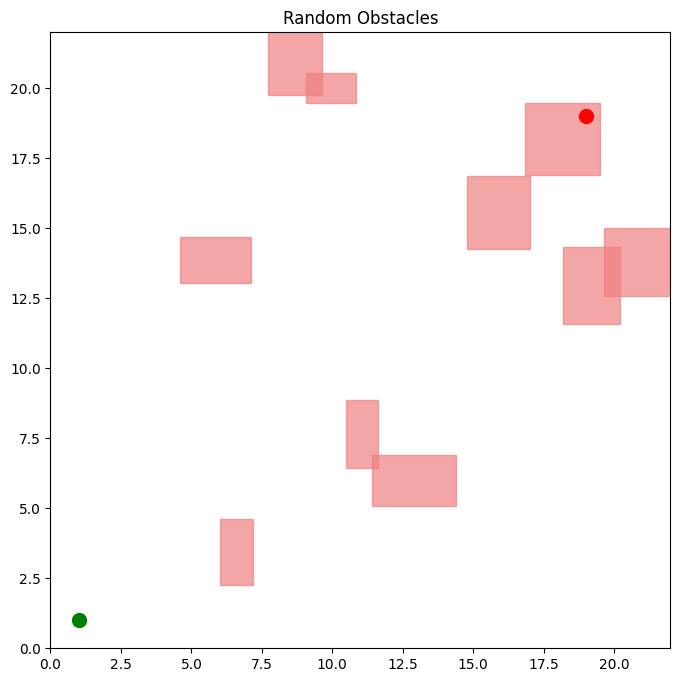

In [2]:
# Plotte alle Szenen zur Überprüfung
for name, (scene, limits, (start, goal)) in scenes:
    fig, ax = plt.subplots(figsize=(8, 8))
    for shape in scene.values():
        xs, ys = shape.exterior.xy if hasattr(shape, 'exterior') else shape.xy
        ax.fill(xs, ys, color='lightcoral', alpha=0.7)
    # Zeichne Start- und Zielpunkte
    ax.plot(start[0], start[1], 'go', markersize=10)
    ax.plot(goal[0], goal[1], 'ro', markersize=10)
    ax.set_title(name)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    plt.show()

In [17]:
# --- Konfiguration für den globalen Planer (VisibilityPRM) ---
config_high = {
    "ntry": 100,  # Anzahl der Versuche für die Roadmap
    "kNearest": 10,  # Anzahl der nächsten Nachbarn
    "maxIterations": 20  # Maximale Iterationen für den globalen Planer
}

config_low = {
    "initialRoadmapSize": 100,
    "updateRoadmapSize": 20,
    "kNearest": 8,
    "maxIterations": 10
}

config_low_basic = {
    "numNodes": 100,
    "radius": 3.0
}


In [18]:
# check all scenes and safe them in a list
scenes = get_all_scenes()
# check all scenes for collision checking
for name, (scene, limits, (start, goal)) in scenes:
    print(f"Scene: {name}, Limits: {limits}, Start: {start}, Goal: {goal}")


Scene: U-Shape, Limits: ((0, 22), (0, 22)), Start: (2.0, 20.0), Goal: (20.0, 2.0)
Scene: L-Shape, Limits: ((0, 22), (0, 22)), Start: (2.0, 2.0), Goal: (15.0, 15.0)
Scene: Cross-Shape, Limits: ((0, 22), (0, 22)), Start: (10, 10.0), Goal: (12.5, 15.0)
Scene: Corridor, Limits: ((0, 20), (0, 20)), Start: (10.0, 5.0), Goal: (10.0, 15.0)
Scene: Complex Shape, Limits: ((0, 22), (0, 22)), Start: (5.0, 5.0), Goal: (17.5, 5.0)
Scene: Multiple Obstacles, Limits: ((0, 22), (0, 22)), Start: (1.0, 1.0), Goal: (15.0, 5.0)
Scene: Random Obstacles, Limits: ((0, 22), (0, 22)), Start: (1.0, 1.0), Goal: (19.0, 19.0)


In [19]:
# --- Planer aufsetzen ---
scene_data = next((data for name, data in scenes if name == "Complex Shape"), None)
if scene_data:
    scene, limits, (start, goal) = scene_data
else:
    raise ValueError("Shape Szene nicht gefunden")
collision_checker = CollisionChecker(scene, limits)
start = [[5, 5]]
goal = [[17.5, 5]]
hier_planner = HierarchicalPlanner(
    scene=scene,
    limits=limits,
    GlobalPlannerClass=VisibilityPRM,
    LocalPlannerClass=LazyPRM,
    config_global=config_high,
    config_local=config_low
)


Globaler Pfad: ['start', 182, 2, 56, 0, 31, 'goal']
Koordinaten des globalen Pfads: [[5, 5], array([5.91899564, 4.27529257]), array([ 3.16381642, 16.24179345]), array([ 9.27687316, 20.76550028]), array([17.72070795, 18.16792772]), array([18.60502137,  4.21549676]), [17.5, 5]]
Segment 0: [5, 5] → [5.91899564 4.27529257]
→ Lokaler Planner für Segment 0: [5, 5] → [5.91899564 4.27529257]
   Lokale Begrenzung (geclipped): ((np.float64(4.28913298966887), np.float64(6.629862645571388)), (np.float64(3.4672814591814882), np.float64(5.808011115084006)))
Segment 1: [5.91899564 4.27529257] → [ 3.16381642 16.24179345]
→ Lokaler Planner für Segment 1: [5.91899564 4.27529257] → [ 3.16381642 16.24179345]
   Lokale Begrenzung (geclipped): ((0, np.float64(12.541406026617711)), (np.float64(2.25854301446984), np.float64(18.25854301446984)))
Segment 2: [ 3.16381642 16.24179345] → [ 9.27687316 20.76550028]
→ Lokaler Planner für Segment 2: [ 3.16381642 16.24179345] → [ 9.27687316 20.76550028]
   Lokale Begre

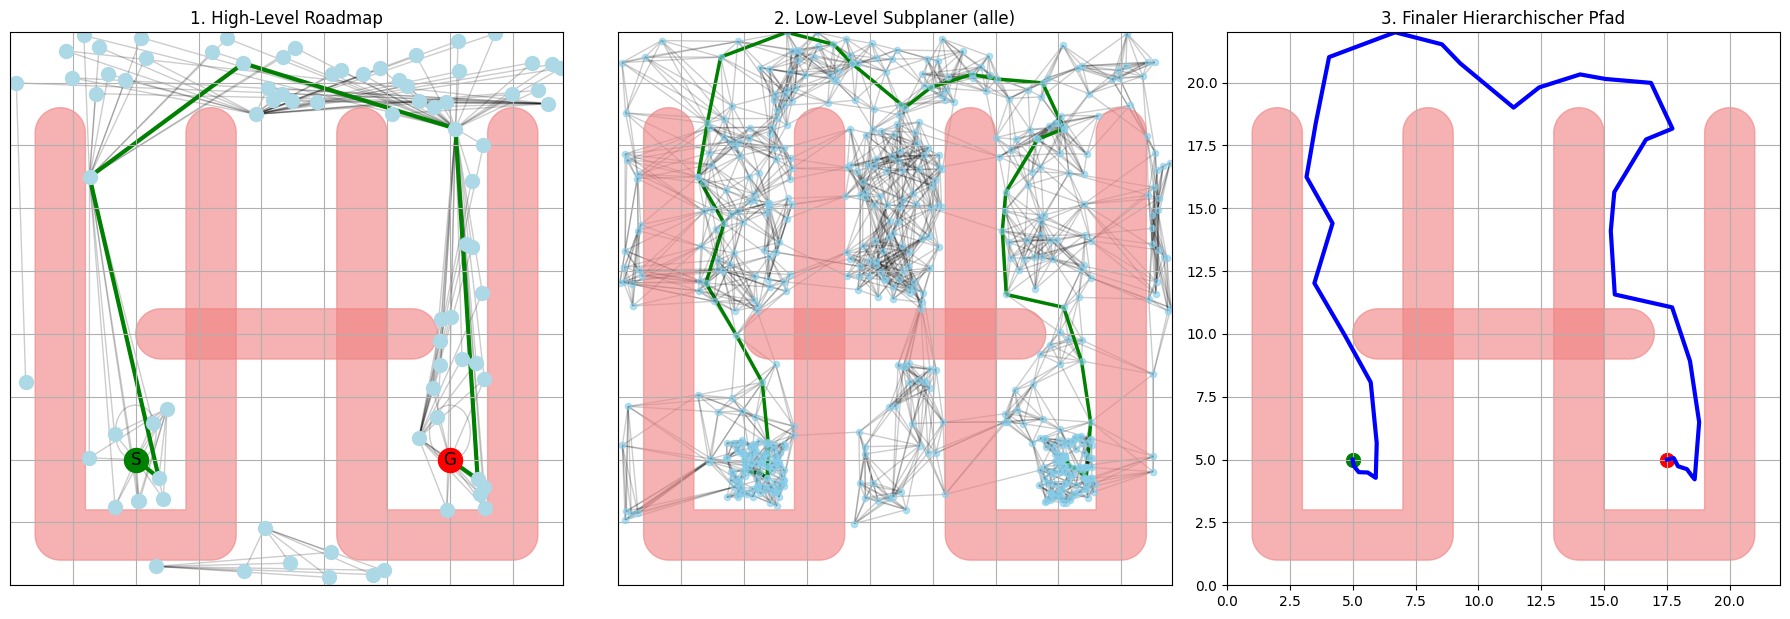

In [20]:
# --- Pfadplanung ---
path = hier_planner.plan_path(start, goal)
if not path:
    print("❌ Kein Pfad gefunden.")
else:
    print("✅ Pfad gefunden mit", len(path), "Punkten")

    # Korrekte Reihenfolge der Initialisierung für die Visualisierung
    hier_planner.solution_path = path  # Statt final_path
    hier_planner.graph = hier_planner.global_planner.graph  # Verwende direkt den globalen Planer-Graph

    collision_checker = CollisionChecker(hier_planner.scene, hier_planner.limits)
    visualize_hierarchical_planning(hier_planner, collision_checker, hier_planner.config_local)
